# Differential expression analysis

Notebook describing creation of count matrix, normalisation and differential expression analysis between treated and untreated cardiomyocytes.
Following the RNA-seq workflow from bioconductor: https://www.bioconductor.org/packages/devel/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html

# Load libraries

In [1]:
suppressPackageStartupMessages({library(Rsubread)
                                library(DESeq2)
                                library("dplyr")
                                library("ggplot2")
                                library("pheatmap")
                                library("RColorBrewer")
                                library(AnnotationDbi)
                                library(org.Dr.eg.db)
                                library(repr)
                                library(topGO)
                                library(GOstats)
                               })


groupGOTerms: 	GOBPTerm, GOMFTerm, GOCCTerm environments built.



In [2]:
packageVersion("DESeq2")

[1] ‘1.29.7’

In [3]:
# set size of plot windows
options(repr.plot.width=12, repr.plot.height=10)

## Rsubread
First create count matrix with Rsubread: https://bioconductor.org/packages/3.12/bioc/vignettes/Rsubread/inst/doc/Rsubread.pdf

List paths to all treatment conditions

In [5]:
bamfiles<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped_trimmed", pattern= "*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles2<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "Blebb[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles3<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "DMSO[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles4<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "cmV[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)
bamfiles5<-list.files(path= "/fast/AG_Ohler/Alison/panakova_CM_RNAseq/data/mapped", pattern= "cmC[^/]*/*.Aligned.out.bam", full.names=TRUE, recursive=TRUE)

Select bam files belonging to the experimental condition we wish to compare.

In [8]:
bamfiles_all<-c(bamfiles2, bamfiles3)


In [9]:
mycounts <- featureCounts(bamfiles_all, annot.ext="/fast/AG_Ohler/Alison/reference_genomes/danrer11/Danio_rerio.GRCz11.100.gtf", isGTFAnnotationFile=TRUE, isPairedEnd=FALSE, countMultiMappingReads = FALSE)


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
       Rsubread 2.3.9

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 6 BAM files                                      ||
||                                                                            ||
||                           Blebbicm1.Aligned.out.bam                        ||
||                           Blebbicm2.Aligned.out.bam                        ||
||                           Blebbicm3.Aligned.out.ba

## Import count matrix into DESeq2

Now import count matrix into DESeq2 with DESeqDataSetFromMatrix (see 3.2 Starting from count matrices).

In [11]:
countData<-mycounts$counts
allsamples<-read.csv("/fast/AG_Ohler/Alison/panakova_CM_RNAseq/mapped_trimmed_samplesheet_batches_macrogen.txt", sep="\t", header=TRUE)

colData<-rbind(allsamples[( allsamples$expt=="expt1" & (allsamples$condition=="bleb")),],
               allsamples[( allsamples$expt=="expt1" & (allsamples$condition=="dmso")),] 
              )
colnames(colData)

[1] "path"       "samplename" "condition"  "expt"

In [12]:
dds <- DESeqDataSetFromMatrix(countData = countData,
                                 colData = colData,
                              design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


# Exploratory analysis and visualization

## Prefiltering the dataset

Removing rows with no counts or only a single count across all samples. NB may come back and adjust this


In [13]:
nrow(dds)

[1] 32520

In [14]:
# check that col data matches bam file names
#dds
#colData(dds)

In [15]:
keep <- rowSums(counts(dds)) > 1
# at least 3 samples with a count of 10 or higher
#keep <- rowSums(counts(dds) >= 1) >= 3
dds <- dds[keep,]
nrow(dds)

[1] 28795

## The variance stabilizing transformation and the rlog

Normalization here is aimed to stabilise the variance across the mean, for the purposes of plotting. If you just take counts, the largest counts have the highest absolute variance. If you take log2+1 of counts, the smaller counts will be over-represented in the variance. DESeq2 has two methods to deal with this now - VST and rlog. The rlog tends to work well on small datasets (n < 30), potentially outperforming the VST when there is a wide range of sequencing depth across samples (an order of magnitude difference). => Use rlog here, but it takes longer to compute

In [16]:
vsd <- vst(dds, blind = FALSE) # can try blind=TRUE for completely unsupervised

In [17]:
rld <- rlog(dds, blind = FALSE) # can try blind=TRUE for completely unsupervised

Inspect how different normalisations affect the variance across the mean.
To show the effect of the transformation, in the figure below we plot the first sample against the second, first simply using the log2 function (after adding 1, to avoid taking the log of zero), and then using the VST and rlog-transformed values.

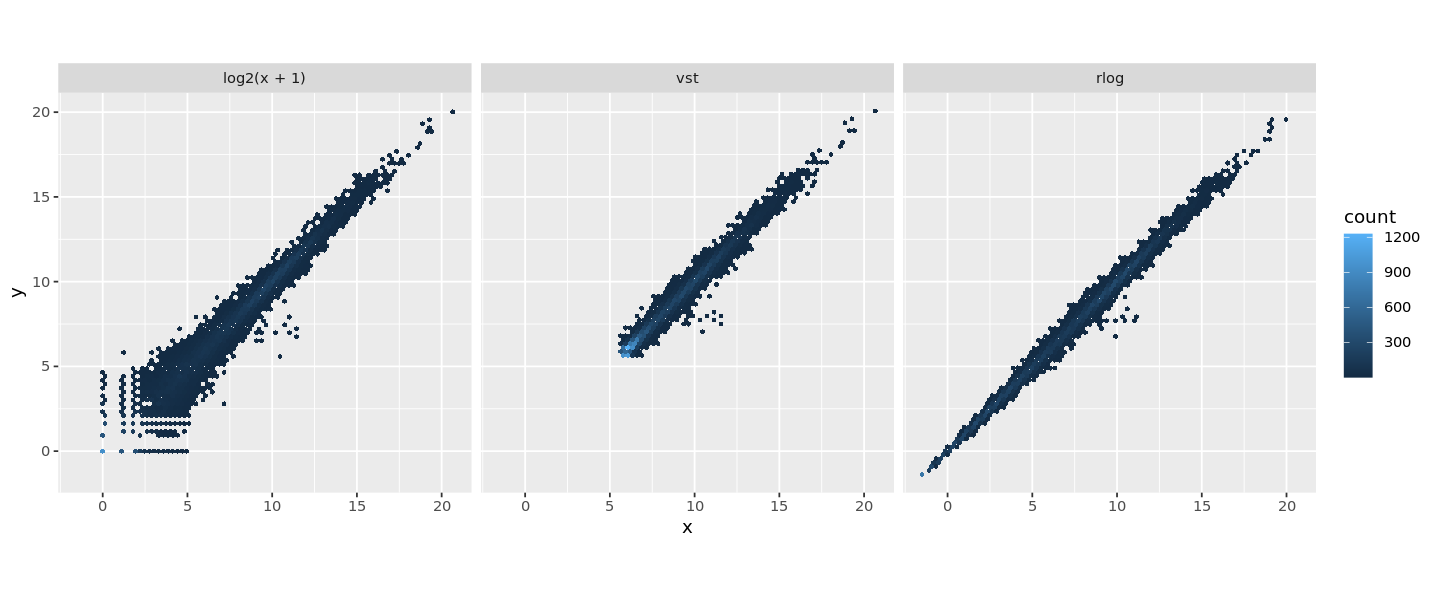

In [24]:
dds <- estimateSizeFactors(dds)

df <- bind_rows(
  as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>%
         mutate(transformation = "log2(x + 1)"),
  as_data_frame(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"),
  as_data_frame(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"))
  
colnames(df)[1:2] <- c("x", "y")  

lvls <- c("log2(x + 1)", "vst", "rlog")
df$transformation <- factor(df$transformation, levels=lvls)

options(repr.plot.width=12, repr.plot.height=5)
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) +
  coord_fixed() + facet_grid( . ~ transformation)  

Compare the sample distances using each normalisation

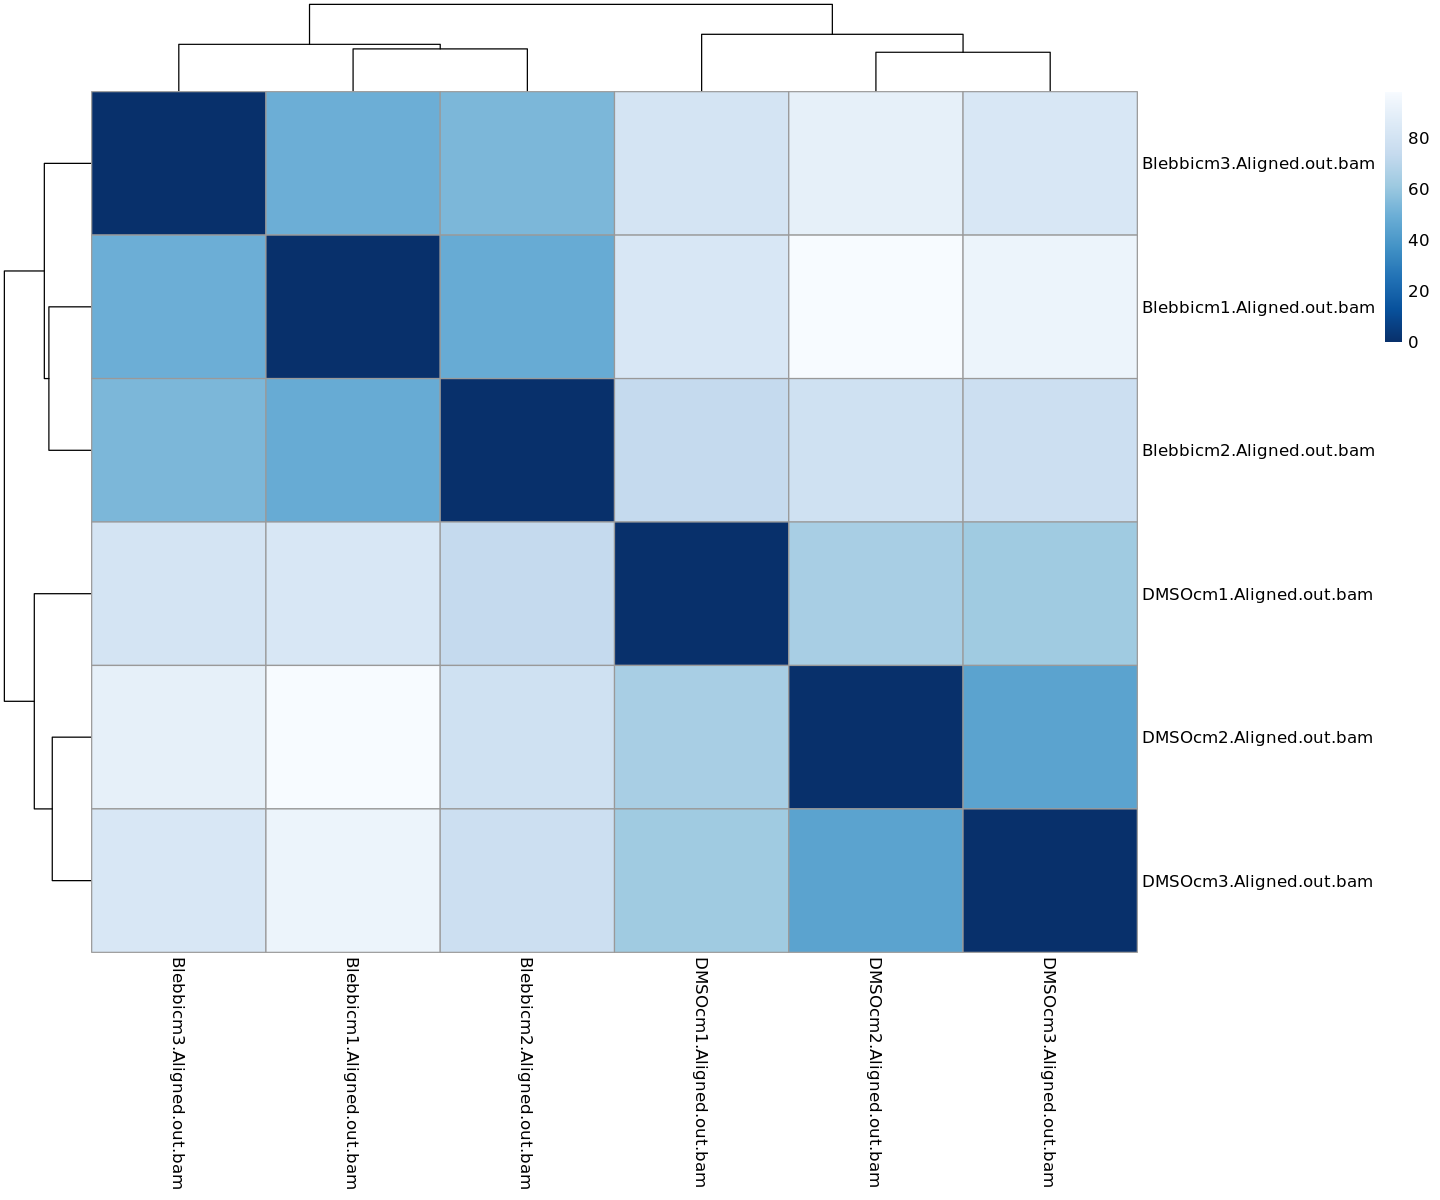

In [25]:
sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix( sampleDists )

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
options(repr.plot.width=12, repr.plot.height=10)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors
        )


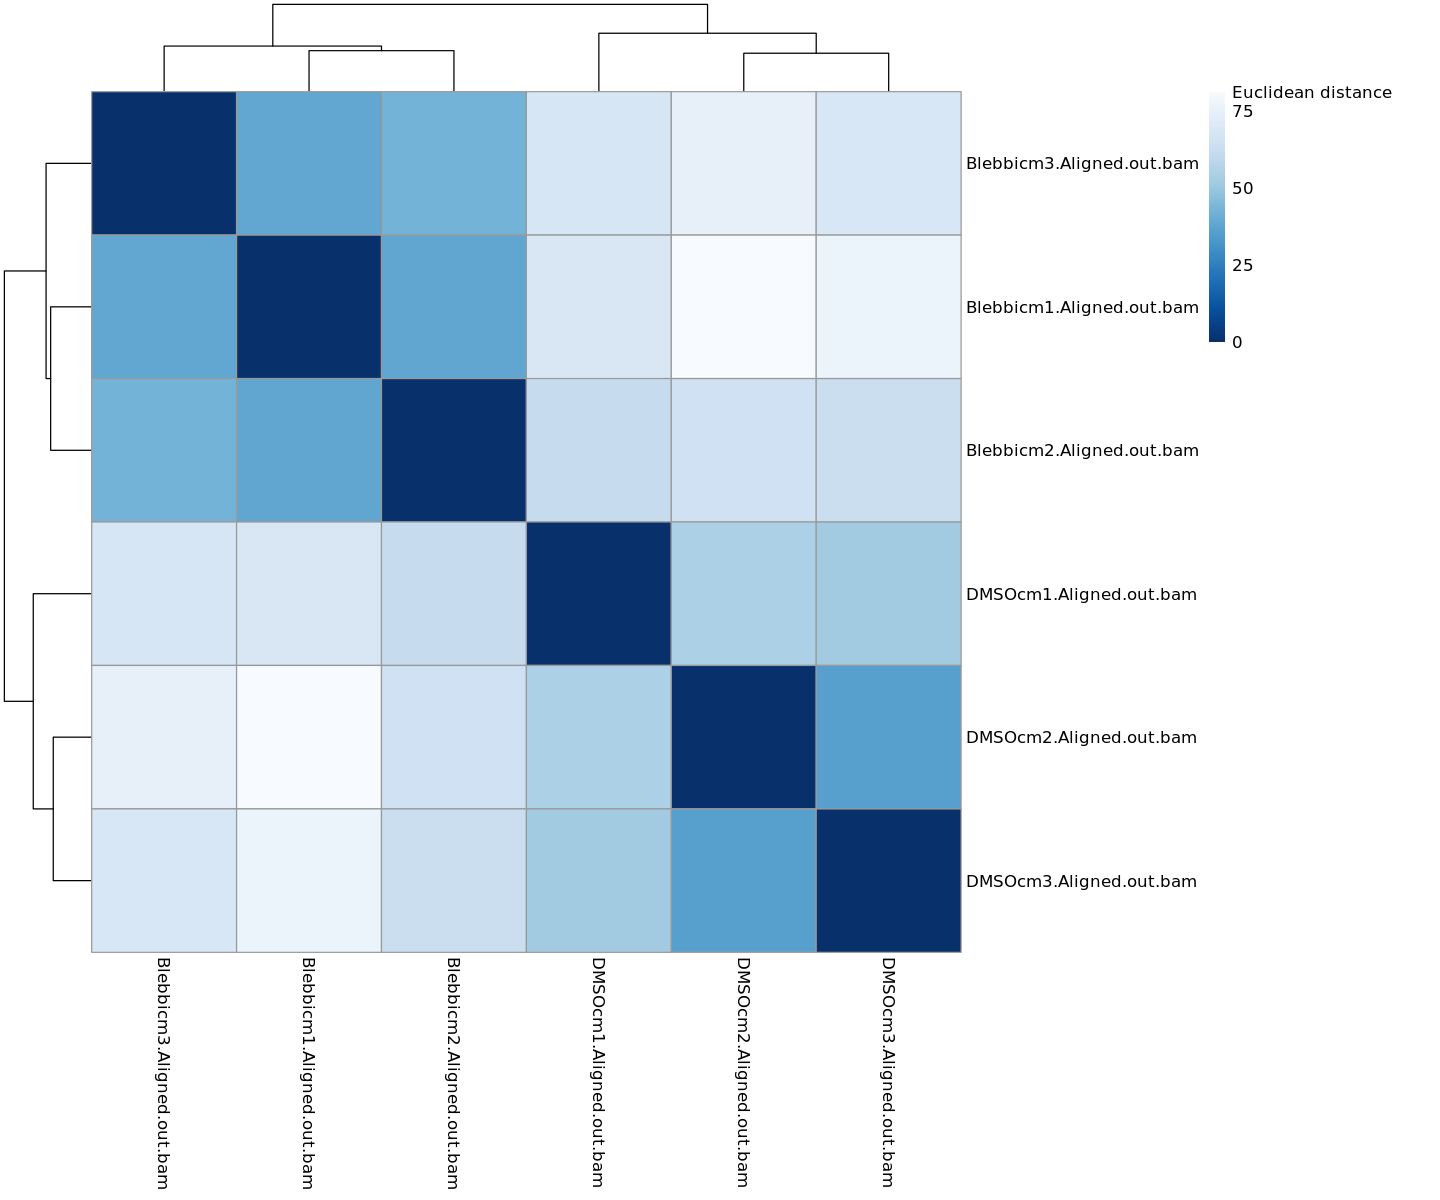

In [22]:
sampleDists_rld <- dist(t(assay(rld)))
sampleDistMatrix_rld <- as.matrix( sampleDists_rld )

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix_rld,
         clustering_distance_rows = sampleDists_rld,
         clustering_distance_cols = sampleDists_rld,
         col = colors,
         legend_breaks = c(0, 25, 50, 75, max(sampleDistMatrix_rld)),
         legend_labels = c("0", "25", "50", "75", "Euclidean distance"),
         width=7,
         height=5
        )

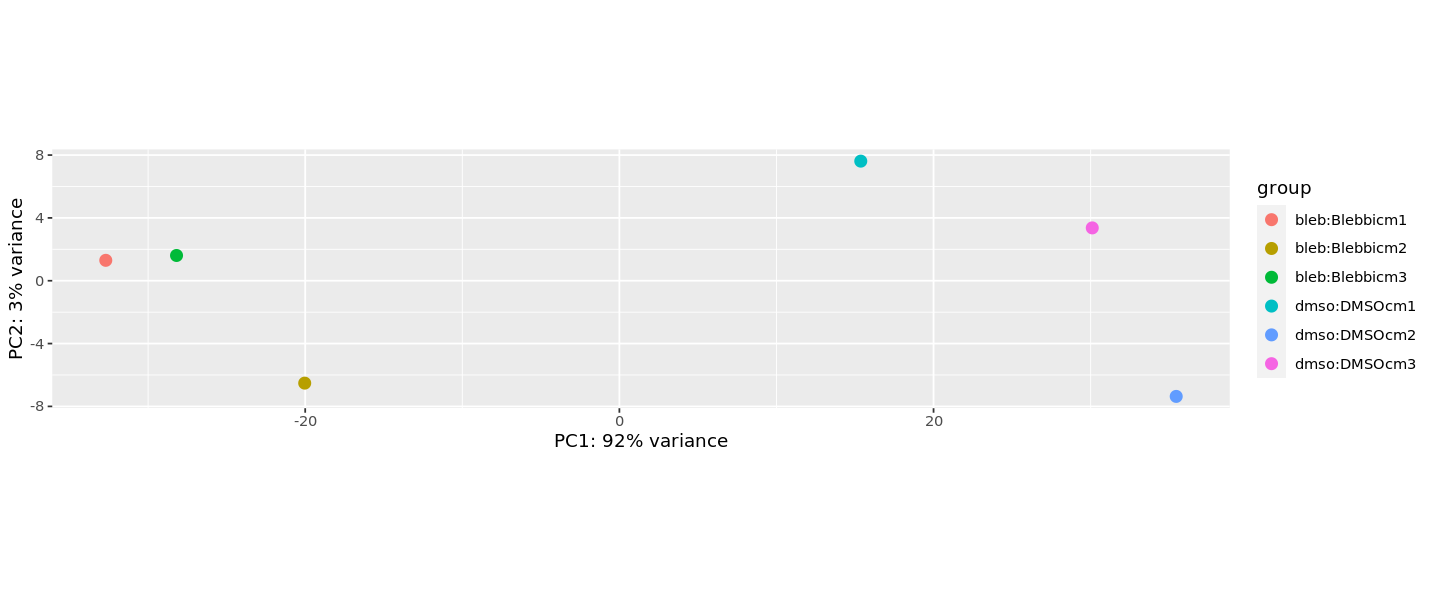

In [26]:
options(repr.plot.width=12, repr.plot.height=5)
plotPCA(vsd, intgroup=c("condition","samplename"))

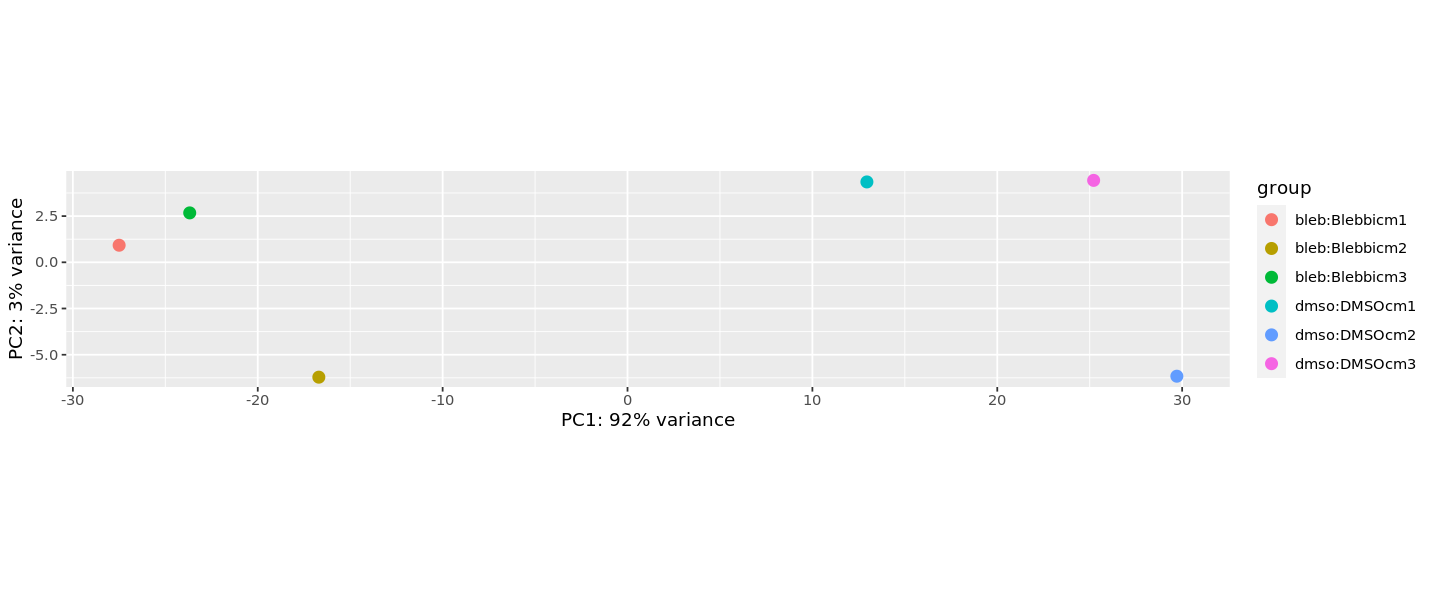

In [27]:
plotPCA(rld, intgroup=c("condition","samplename"))

Regardless of normalisation procedure the samples group clearly by treatment condition.

## Differential expression analysis

As we have already specified an experimental design when we created the DESeqDataSet, we can run the differential expression pipeline on the raw counts with a single call to the function DESeq:

This function will print out a message for the various steps it performs. These are described in more detail in the manual page for DESeq, which can be accessed by typing ?DESeq. Briefly these are: the estimation of size factors (controlling for differences in the sequencing depth of the samples), the estimation of dispersion values for each gene, and fitting a generalized linear model.

A DESeqDataSet is returned that contains all the fitted parameters within it, and the following section describes how to extract out results tables of interest from this object.

In [29]:
dds <- DESeq(dds)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [30]:
res <- results(dds, contrast=c("condition","bleb","dmso"))
colnames(res)

[1] "baseMean"       "log2FoldChange" "lfcSE"          "stat"          
[5] "pvalue"         "padj"

### select significant genes between bleb and dmso

In [31]:
sum(res$padj < 0.05, na.rm=TRUE)
resSig <- subset(res, padj < 0.05)
resSig <- subset(resSig, abs(log2FoldChange) > 1)
dim(resSig)
sum(resSig$log2FoldChange > 1, na.rm=TRUE)
sum(resSig$log2FoldChange < -1, na.rm=TRUE)

[1] 1979

[1] 1161    6

[1] 986

[1] 175

### annotate genes with gene names

In [33]:
# using Danio rerio annotations
columns(org.Dr.eg.db)

[1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GO"           "GOALL"        "IPI"          "ONTOLOGY"     "ONTOLOGYALL" 
[16] "PATH"         "PFAM"         "PMID"         "PROSITE"      "REFSEQ"      
[21] "SYMBOL"       "UNIGENE"      "UNIPROT"      "ZFIN"

In [34]:
ens.str <- substr(rownames(res), 1, length(rownames(res)))
res$symbol <- mapIds(org.Dr.eg.db,
                     keys=ens.str,
                     column="SYMBOL",
                     keytype="ENSEMBL",
                     multiVals="first")
res$entrez <- mapIds(org.Dr.eg.db,
                     keys=ens.str,
                     column="ENTREZID",
                     keytype="ENSEMBL",
                     multiVals="first")

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



Select genes with both a significant fold change and a high effect size (greater than two fold change)

In [35]:
resSig <- subset(res, padj < 0.05)
resSig <- subset(resSig, abs(log2FoldChange) > 1)

## plot heat maps with top and bottom DE genes

In [36]:
#select top and bottom most differential genes
topBotDEGenes<-rbind(head(resSig[ order(-resSig$log2FoldChange), ], 20),
                       head(resSig[ order(resSig$log2FoldChange), ], 20))
#head(topBotDEGenes, 20)

In [37]:
# select bleb and dmso samples
blebdmso_samples<-colData(vsd)[vsd$condition == "bleb" | vsd$condition == "dmso",]

In [46]:
options(repr.plot.width=12, repr.plot.height=10)
mat<-(assay(vsd)[rownames(topBotDEGenes), rownames(blebdmso_samples)])
mat  <- mat - rowMeans(mat)
anno <- as.data.frame(colData(vsd)[rownames(blebdmso_samples), "condition", drop=FALSE]) # drop=FALSE allows you to select just one column of dataframe

labels_col = c(colData(vsd)[rownames(blebdmso_samples), "samplename"])
labels_row = c(topBotDEGenes$symbol)
#pheatmap(mat, annotation_col = anno, labels_col = labels_col, labels_row = labels_row, cluster_rows=FALSE)


### Heatmap with all DE genes between samples

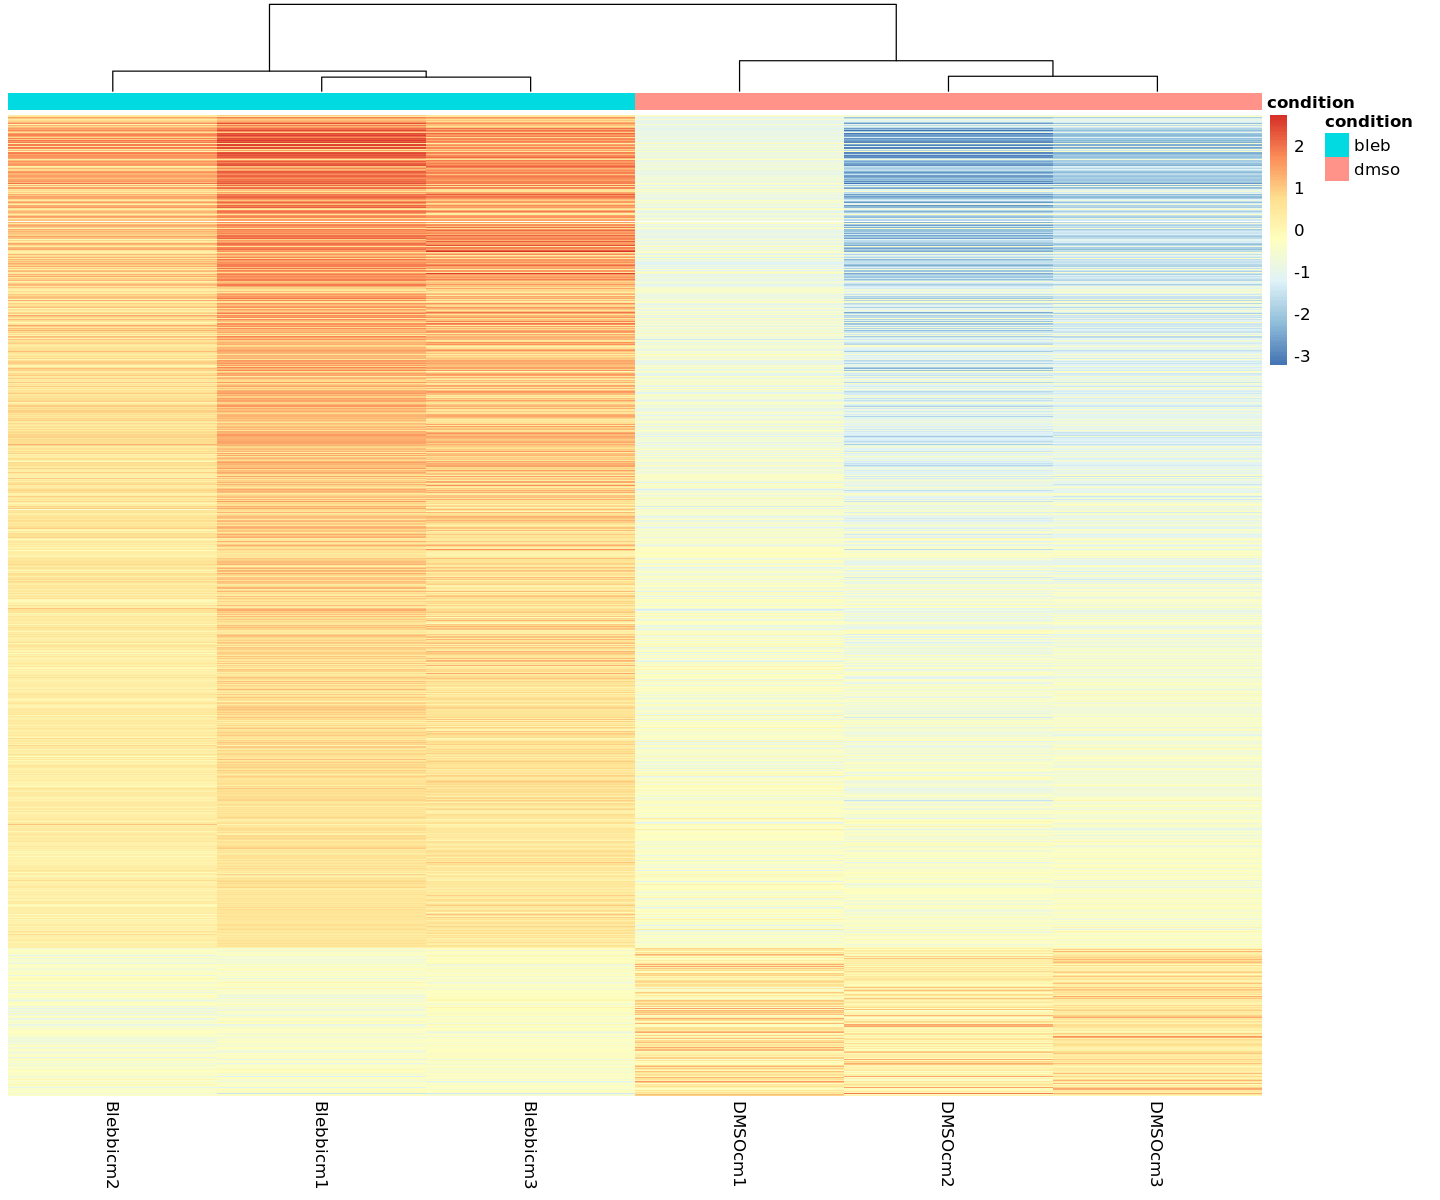

In [40]:
allDEGenes<-resSig[ order(-resSig$log2FoldChange), ]

matall<-(assay(vsd)[rownames(allDEGenes), rownames(blebdmso_samples)])
matall  <- matall - rowMeans(matall)
anno <- as.data.frame(colData(vsd)[rownames(blebdmso_samples), "condition", drop=FALSE]) # drop=FALSE allows you to select just one column of dataframe

labels_col = c(colData(vsd)[rownames(blebdmso_samples), "samplename"])
pheatmap(matall, annotation_col = anno, labels_col = labels_col, cluster_rows=FALSE, show_rownames=FALSE)


## volcano plot
Our collaborator would like to display significantly differentially expressed genes with a volcano plot

[1] 20418     8

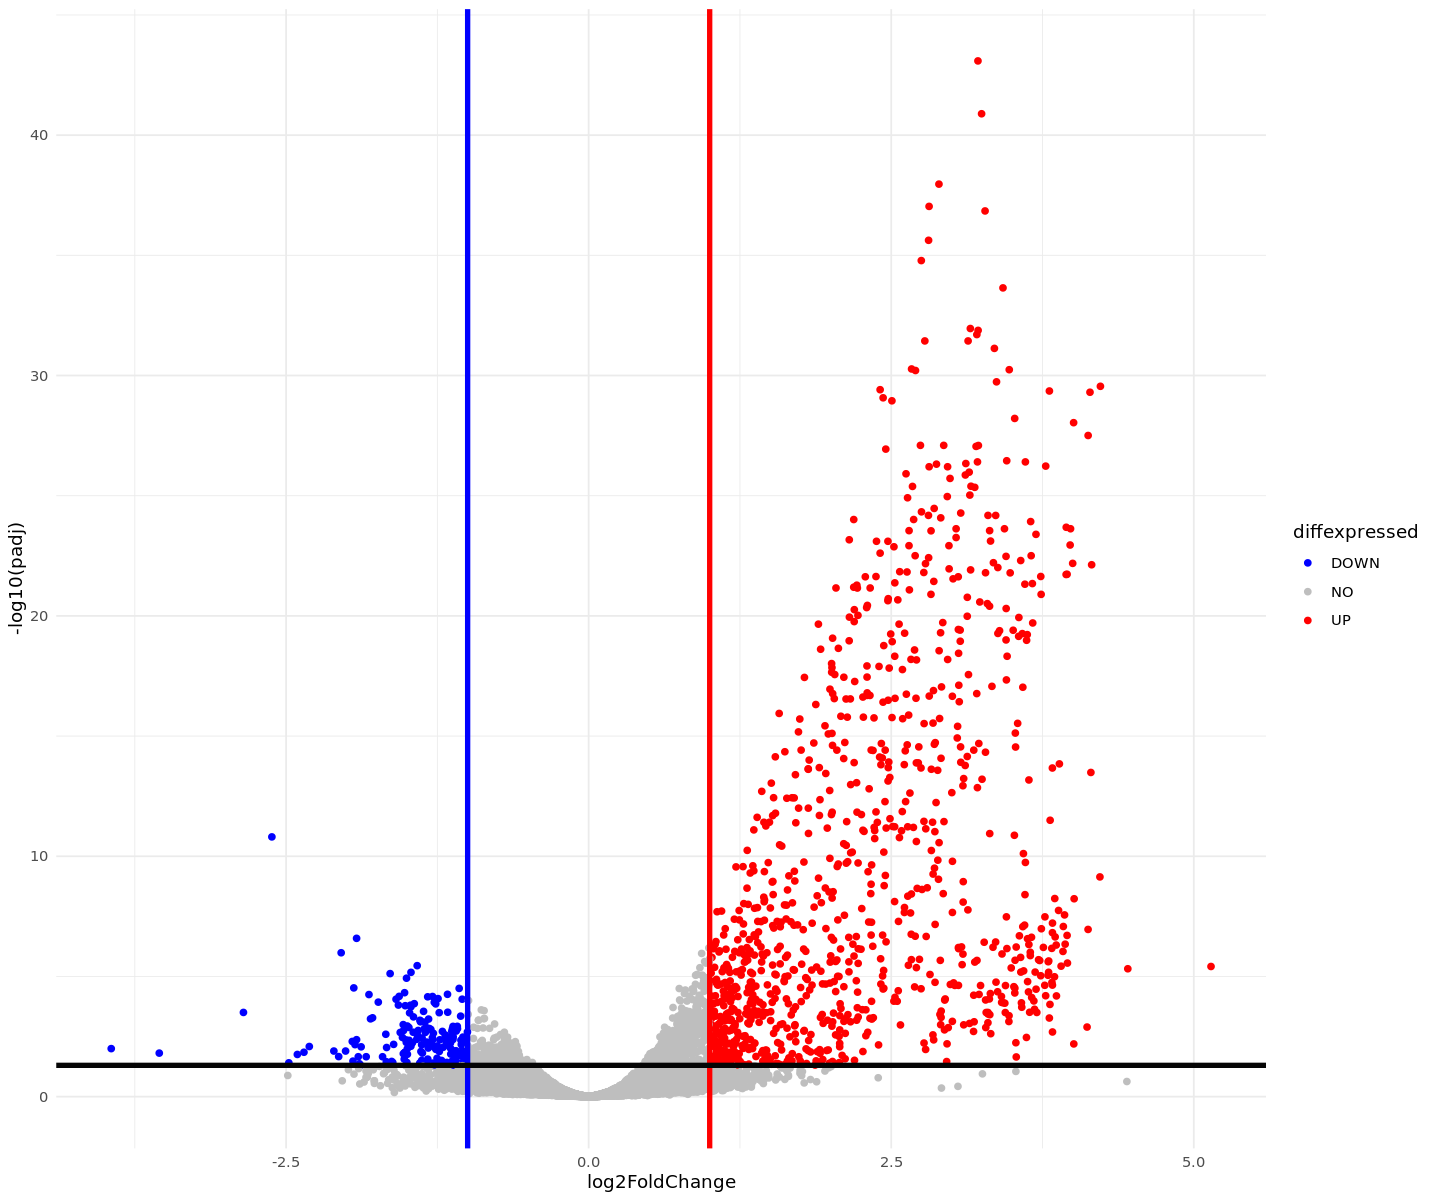

In [43]:
de<-data.frame(subset(res, padj != 0))
#de<-data.frame(subset(res))
dim(de)
de$delabel <- NA
de$symbol <- as.factor(de$symbol)
# add a column of NAs
de$diffexpressed <- "NO"
# if log2Foldchange > 1 and pvalue < 0.05, set as "UP" 
de$diffexpressed[de$log2FoldChange > 1 & de$padj < 0.05] <- "UP"
# if log2Foldchange < -1 and pvalue < 0.05, set as "DOWN"
de$diffexpressed[de$log2FoldChange < -1 & de$padj < 0.05] <- "DOWN"

# show only labels of significant DE genes
de$delabel[de$log2FoldChange > 5 | -log10(de$padj) > 30] <- as.character(de$symbol[de$log2FoldChange > 5 | -log10(de$padj) > 30])
de$delabel[(de$log2FoldChange < -2.5) | (de$log2FoldChange < -1 & -log10(de$padj) > 7)] <- as.character(de$symbol[(de$log2FoldChange < -2.5) | (de$log2FoldChange < -1 & -log10(de$padj) > 7)])

# the final plot (without labels here for clarity)
plot2<-ggplot(data=de, aes(x=log2FoldChange, y=-log10(padj), col=diffexpressed)) + 
    geom_point() + 
    theme_minimal()+
    scale_color_manual(values=c("blue", "grey", "red"))+
    geom_vline(xintercept = -1, color = "blue", size=1.5)+
    geom_vline(xintercept = 1, color = "red", size=1.5)+
    geom_hline(yintercept = -log10(0.05), color = "gray2", size=1.5)
plot2


Write significant DE genes to a file for sharing with collaborators

In [44]:
resSigOrdered <- resSig[order(-resSig$log2FoldChange),]
resSigOrderedDF <- as.data.frame(resSigOrdered)

#write.csv(resSigOrderedDF, file = "deseq2_macrogen_bleb//resultsDElogFC1padj0.05_bleb_dmso.csv")


Write table with all genes (not just DE)

In [45]:
# this includes all genes but not those with expression too low to call DE (see penultimate paragraph of 5.2 https://www.bioconductor.org/packages/devel/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#building-the-results-table)
res2<-data.frame(subset(res, padj != 0))
resOrdered <- res2[order(-res2$log2FoldChange),]
resOrderedDF <- as.data.frame(resOrdered)
#write.csv(resOrderedDF, file = "deseq2_macrogen_bleb/macrogen_resultsall_bleb_dmso.csv")